In [1]:
import cv2
import torch
import seaborn
import plotly
from sklearn.metrics import confusion_matrix

print("✅ Environment is fully ready")
print("PyTorch:", torch.__version__)

✅ Environment is fully ready
PyTorch: 2.9.1+cpu


Total sketch images: 376
Total photo images: 376


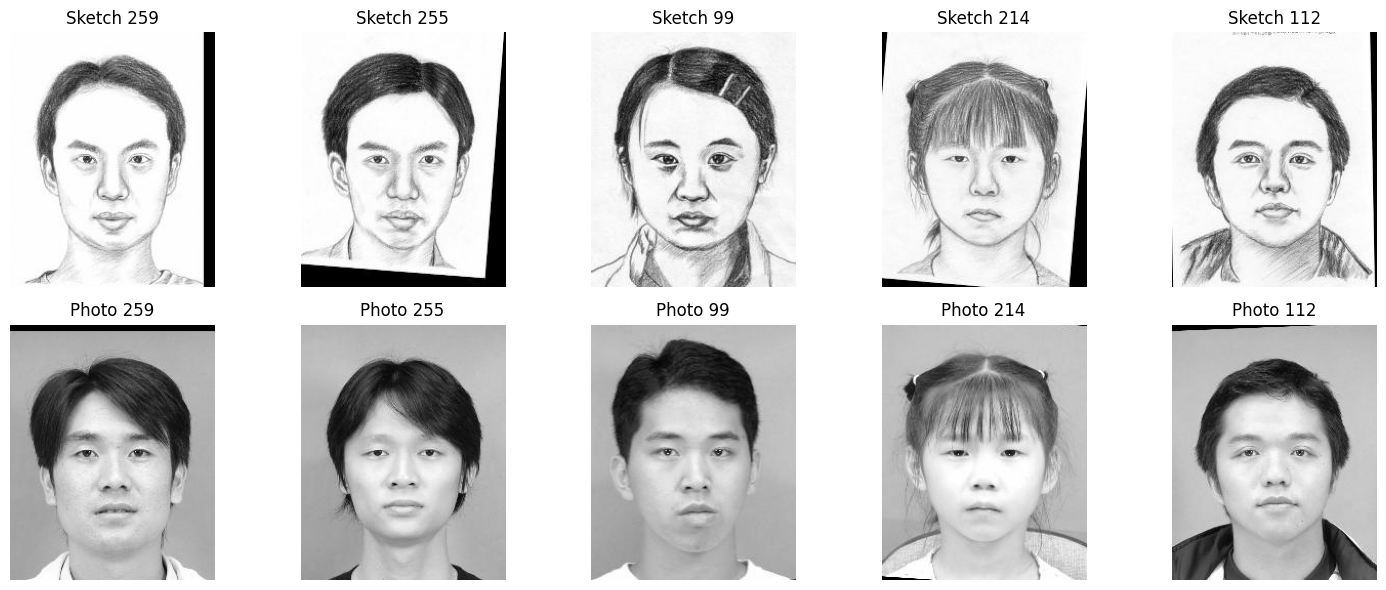

Sample sketch shapes: [(250, 200), (250, 200), (250, 200), (250, 200), (250, 200)]
Sample photo shapes: [(250, 200), (250, 200), (250, 200), (250, 200), (250, 200)]
Most common sketch shape: [((250, 200), 376)]
Most common photo shape: [((250, 200), 376)]
Sketch image statistics:
Mean: 205.76, Std: 71.38, Min: 0, Max: 255
Photo image statistics:
Mean: 155.45, Std: 64.39, Min: 0, Max: 255


In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

sketch_dir = r"E:\19AI702-P1\data\sketches"
photo_dir  = r"E:\19AI702-P1\data\photos"

sketch_files = sorted(os.listdir(sketch_dir))
photo_files  = sorted(os.listdir(photo_dir))

print(f"Total sketch images: {len(sketch_files)}")
print(f"Total photo images: {len(photo_files)}")

assert len(sketch_files) == len(photo_files), "Mismatch between sketches and photos!"

def show_random_pairs(sketch_files, photo_files, sketch_dir, photo_dir, n=5):
    plt.figure(figsize=(n*3, 6))
    sample_indices = random.sample(range(len(sketch_files)), n)
    for i, idx in enumerate(sample_indices):
        sketch = cv2.imread(os.path.join(sketch_dir, sketch_files[idx]), 0)
        photo  = cv2.imread(os.path.join(photo_dir, photo_files[idx]), 0)
        plt.subplot(2, n, i+1)
        plt.imshow(sketch, cmap='gray')
        plt.title(f"Sketch {idx}")
        plt.axis('off')
        plt.subplot(2, n, i+n+1)
        plt.imshow(photo, cmap='gray')
        plt.title(f"Photo {idx}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_random_pairs(sketch_files, photo_files, sketch_dir, photo_dir, n=5)

sketch_shapes = [cv2.imread(os.path.join(sketch_dir, f), 0).shape for f in sketch_files]
photo_shapes  = [cv2.imread(os.path.join(photo_dir, f), 0).shape for f in photo_files]

print("Sample sketch shapes:", sketch_shapes[:5])
print("Sample photo shapes:", photo_shapes[:5])
print("Most common sketch shape:", Counter(sketch_shapes).most_common(1))
print("Most common photo shape:", Counter(photo_shapes).most_common(1))

def image_stats(files, dir_path):
    pixels = []
    for f in files:
        img = cv2.imread(os.path.join(dir_path, f), 0)
        pixels.append(img.flatten())
    pixels = np.concatenate(pixels)
    print(f"Mean: {pixels.mean():.2f}, Std: {pixels.std():.2f}, Min: {pixels.min()}, Max: {pixels.max()}")

print("Sketch image statistics:")
image_stats(sketch_files, sketch_dir)
print("Photo image statistics:")
image_stats(photo_files, photo_dir)


In [3]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import os

sketch_dir = r"E:\19AI702-P1\data\sketches"
photo_dir  = r"E:\19AI702-P1\data\photos"

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((250, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class SketchPhotoDataset(Dataset):
    def __init__(self, sketch_dir, photo_dir, transform=None):
        self.sketch_dir = sketch_dir
        self.photo_dir = photo_dir
        self.sketch_files = sorted(os.listdir(sketch_dir))
        self.photo_files  = sorted(os.listdir(photo_dir))
        self.transform = transform

    def __len__(self):
        return len(self.sketch_files)

    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.sketch_files[idx])
        photo_path  = os.path.join(self.photo_dir, self.photo_files[idx])
        sketch = cv2.imread(sketch_path, 0)
        photo  = cv2.imread(photo_path, 0)
        if self.transform:
            sketch = self.transform(sketch)
            photo  = self.transform(photo)
        return sketch, photo

dataset = SketchPhotoDataset(sketch_dir, photo_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

sample_sketch, sample_photo = next(iter(dataloader))
print("Batch shapes:", sample_sketch.shape, sample_photo.shape)


Batch shapes: torch.Size([16, 1, 250, 200]) torch.Size([16, 1, 250, 200])


In [ ]:
class SketchPhotoDataset(Dataset):
    def __init__(self, sketch_dir, photo_dir, transform=None):
        self.sketch_dir = sketch_dir
        self.photo_dir = photo_dir
        self.sketch_files = sorted(os.listdir(sketch_dir))
        self.photo_files  = sorted(os.listdir(photo_dir))
        self.transform = transform

    def __len__(self):
        return len(self.sketch_files)

    def __getitem__(self, idx):
        sketch = cv2.imread(
            os.path.join(self.sketch_dir, self.sketch_files[idx]), 0
        )
        photo = cv2.imread(
            os.path.join(self.photo_dir, self.photo_files[idx]), 0
        )

        if self.transform:
            sketch = self.transform(sketch)
            photo  = self.transform(photo)

        return sketch, photo


In [ ]:
class TripletDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.length = len(base_dataset)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        anchor, positive = self.base_dataset[idx]

        neg_idx = idx
        while neg_idx == idx:
            neg_idx = random.randint(0, self.length - 1)

        _, negative = self.base_dataset[neg_idx]

        return anchor, positive, negative


In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.3):
        super().__init__()
        self.margin = margin

    def forward(self, a, p, n):
        d_pos = F.pairwise_distance(a, p)
        d_neg = F.pairwise_distance(a, n)
        return torch.mean(torch.clamp(d_pos - d_neg + self.margin, min=0.0))


In [ ]:
def train_triplet_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for a, p, n in loader:
        a, p, n = a.to(device), p.to(device), n.to(device)

        optimizer.zero_grad()

        za = model.embedding_net(a)
        zp = model.embedding_net(p)
        zn = model.embedding_net(n)

        loss = criterion(za, zp, zn)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


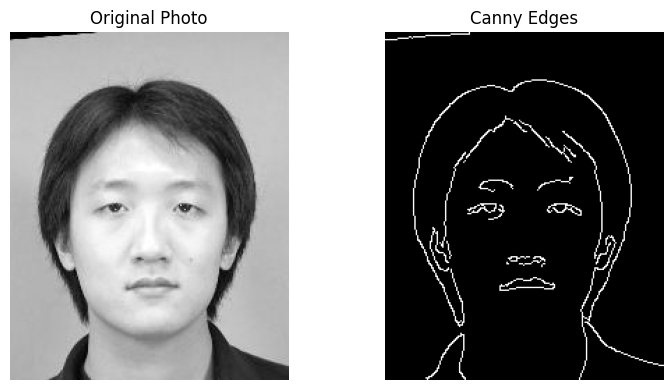

In [5]:
import matplotlib.pyplot as plt
import random
import os

idx = random.randint(0, len(photo_files) - 1)

photo = cv2.imread(os.path.join(photo_dir, photo_files[idx]), 0)
edges = extract_edges(photo)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(photo, cmap='gray')
plt.title("Original Photo")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edges")
plt.axis('off')

plt.tight_layout()
plt.show()


In [66]:
from torch.utils.data import Dataset

class SketchPhotoEdgeDataset(Dataset):
    def __init__(self, sketch_dir, photo_dir, transform=None):
        self.sketch_dir = sketch_dir
        self.photo_dir = photo_dir
        self.sketch_files = sorted(os.listdir(sketch_dir))
        self.photo_files  = sorted(os.listdir(photo_dir))
        self.transform = transform

    def __len__(self):
        return len(self.sketch_files)

    def __getitem__(self, idx):
        sketch = cv2.imread(
            os.path.join(self.sketch_dir, self.sketch_files[idx]), 0
        )
        photo = cv2.imread(
            os.path.join(self.photo_dir, self.photo_files[idx]), 0
        )

    
        photo = cv2.imread(photo_path, 0)

        if self.transform:
            sketch = self.transform(sketch)
            photo  = self.transform(photo)

        return sketch, photo


In [7]:
dataset = SketchPhotoEdgeDataset(sketch_dir, photo_dir, transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

sk, ph = next(iter(loader))
print(sk.shape, ph.shape)


torch.Size([16, 1, 250, 200]) torch.Size([16, 1, 250, 200])


In [9]:
from sklearn.model_selection import train_test_split

dataset_size = len(dataset)
indices = list(range(dataset_size))


train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.30,
    random_state=42,
    shuffle=True
)


val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,
    random_state=42,
    shuffle=True
)

print(f"Train: {len(train_idx)}")
print(f"Validation: {len(val_idx)}")
print(f"Test: {len(test_idx)}")


Train: 263
Validation: 56
Test: 57


In [10]:
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)


In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [12]:
sk, ph = next(iter(train_loader))
print(sk.shape, ph.shape)


torch.Size([16, 1, 250, 200]) torch.Size([16, 1, 250, 200])


In [13]:
import random
import torch
from torch.utils.data import Dataset

class SiamesePairDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.length = len(base_dataset)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        sketch, photo = self.base_dataset[idx]

    
        is_positive = random.choice([0, 1])

        if is_positive:
        
            label = torch.tensor(1, dtype=torch.float32)
            return sketch, photo, label

        else:
        
            neg_idx = idx
            while neg_idx == idx:
                neg_idx = random.randint(0, self.length - 1)

            _, neg_photo = self.base_dataset[neg_idx]
            label = torch.tensor(0, dtype=torch.float32)
            return sketch, neg_photo, label


In [14]:
train_pairs = SiamesePairDataset(train_dataset)
val_pairs   = SiamesePairDataset(val_dataset)
test_pairs  = SiamesePairDataset(test_dataset)


In [ ]:
train_triplet_loader = DataLoader(
    TripletDataset(train_dataset),
    batch_size=16,
    shuffle=True
)

val_triplet_loader = DataLoader(
    TripletDataset(val_dataset),
    batch_size=16,
    shuffle=False
)


In [ ]:
model = SiameseNet(embedding_dim=128).to(device)
criterion = TripletLoss(margin=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30
for epoch in range(num_epochs):
    loss = train_triplet_epoch(
        model, train_triplet_loader, optimizer, criterion
    )
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss:.4f}")


In [16]:
s, p, y = next(iter(train_loader))
print(s.shape, p.shape, y.shape)
print(y[:10])


torch.Size([16, 1, 250, 200]) torch.Size([16, 1, 250, 200]) torch.Size([16])
tensor([0., 1., 0., 0., 0., 1., 1., 0., 1., 1.])


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    
    
        self.fc = nn.Sequential(
            nn.Linear(128 * 31 * 25, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, embedding_dim)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)


In [18]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.embedding_net = EmbeddingNet(embedding_dim)

    def forward(self, x1, x2):
        z1 = self.embedding_net(x1)
        z2 = self.embedding_net(x2)
        return z1, z2


In [19]:
model = SiameseNet(embedding_dim=128)

s, p, y = next(iter(train_loader))
z1, z2 = model(s, p)

print(z1.shape, z2.shape)


torch.Size([16, 128]) torch.Size([16, 128])


In [20]:
dist = F.pairwise_distance(z1, z2)

In [21]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, z1, z2, label):
    
        dist = F.pairwise_distance(z1, z2)

    
        loss = torch.mean(
            label * torch.pow(dist, 2) +
            (1 - label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2)
        )
        return loss


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SiameseNet(embedding_dim=128).to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [23]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for sketch, photo, label in loader:
        sketch = sketch.to(device)
        photo  = photo.to(device)
        label  = label.to(device)

        optimizer.zero_grad()

        z1, z2 = model(sketch, photo)
        loss = criterion(z1, z2, label)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [24]:
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for sketch, photo, label in loader:
            sketch = sketch.to(device)
            photo  = photo.to(device)
            label  = label.to(device)

            z1, z2 = model(sketch, photo)
            loss = criterion(z1, z2, label)

            total_loss += loss.item()

    return total_loss / len(loader)


In [25]:
num_epochs = 25
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss = validate(
        model, val_loader, criterion
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )


Epoch [1/25] Train Loss: 0.2978 | Val Loss: 0.3210
Epoch [2/25] Train Loss: 0.2534 | Val Loss: 0.3996
Epoch [3/25] Train Loss: 0.2549 | Val Loss: 0.4688
Epoch [4/25] Train Loss: 0.2483 | Val Loss: 0.3614
Epoch [5/25] Train Loss: 0.2495 | Val Loss: 0.3954
Epoch [6/25] Train Loss: 0.2469 | Val Loss: 0.4505
Epoch [7/25] Train Loss: 0.2515 | Val Loss: 0.5245
Epoch [8/25] Train Loss: 0.2542 | Val Loss: 0.3846
Epoch [9/25] Train Loss: 0.2507 | Val Loss: 0.4287
Epoch [10/25] Train Loss: 0.2524 | Val Loss: 0.4359
Epoch [11/25] Train Loss: 0.2468 | Val Loss: 0.4488
Epoch [12/25] Train Loss: 0.2556 | Val Loss: 0.4207
Epoch [13/25] Train Loss: 0.2578 | Val Loss: 0.3816
Epoch [14/25] Train Loss: 0.2517 | Val Loss: 0.4734
Epoch [15/25] Train Loss: 0.2461 | Val Loss: 0.3240
Epoch [16/25] Train Loss: 0.2549 | Val Loss: 0.3613
Epoch [17/25] Train Loss: 0.2555 | Val Loss: 0.3061
Epoch [18/25] Train Loss: 0.2563 | Val Loss: 0.4475
Epoch [19/25] Train Loss: 0.2505 | Val Loss: 0.5031
Epoch [20/25] Train L

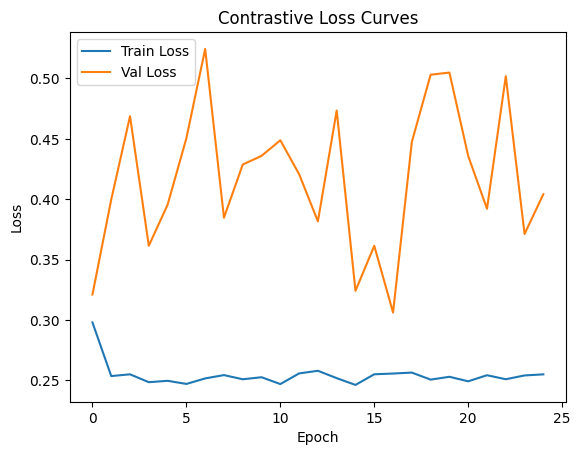

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Contrastive Loss Curves")
plt.show()


In [27]:
model.eval()

SiameseNet(
  (embedding_net): EmbeddingNet(
    (features): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=99200, out_features=512, bias=True)
      (1): ReL

In [28]:
import torch

def extract_embeddings(model, loader):
    embeddings_sketch = []
    embeddings_photo = []

    with torch.no_grad():
        for sketch, photo, _ in loader:
            sketch = sketch.to(device)
            photo  = photo.to(device)

            z1, z2 = model(sketch, photo)

            embeddings_sketch.append(z1.cpu())
            embeddings_photo.append(z2.cpu())

    embeddings_sketch = torch.cat(embeddings_sketch, dim=0)
    embeddings_photo  = torch.cat(embeddings_photo, dim=0)

    return embeddings_sketch, embeddings_photo


In [29]:
test_sketch_embeds, test_photo_embeds = extract_embeddings(
    model, test_loader
)

print(test_sketch_embeds.shape)
print(test_photo_embeds.shape)


torch.Size([57, 128])
torch.Size([57, 128])


In [30]:
import torch.nn.functional as F


pos_dist = F.pairwise_distance(
    test_sketch_embeds,
    test_photo_embeds
)


neg_dist = F.pairwise_distance(
    test_sketch_embeds,
    test_photo_embeds.roll(shifts=1, dims=0)
)

print("Positive distance mean:", pos_dist.mean().item())
print("Negative distance mean:", neg_dist.mean().item())


Positive distance mean: 0.09159965813159943
Negative distance mean: 0.09900230169296265


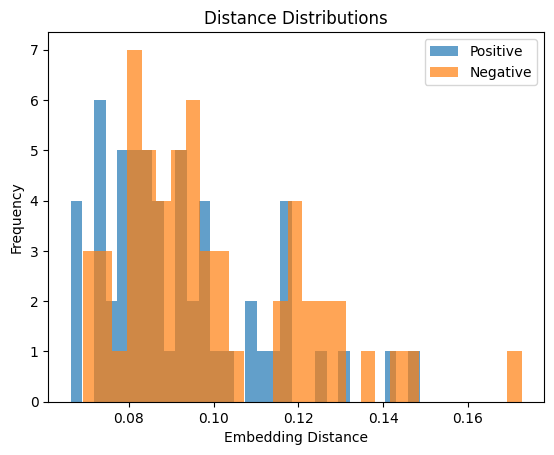

In [31]:
import matplotlib.pyplot as plt

plt.hist(pos_dist.numpy(), bins=30, alpha=0.7, label="Positive")
plt.hist(neg_dist.numpy(), bins=30, alpha=0.7, label="Negative")
plt.legend()
plt.xlabel("Embedding Distance")
plt.ylabel("Frequency")
plt.title("Distance Distributions")
plt.show()


In [32]:
import torch.nn.functional as F

def euclidean_distance(a, b):
    return F.pairwise_distance(a, b)


In [33]:
def cosine_similarity(a, b):
    return F.cosine_similarity(a, b)


In [34]:
import torch

def compute_distance_matrix(sketch_embeds, photo_embeds):
    """
    Returns: [num_sketches, num_photos] distance matrix
    """
    num_sketches = sketch_embeds.size(0)
    num_photos = photo_embeds.size(0)

    dist_matrix = torch.zeros(num_sketches, num_photos)

    for i in range(num_sketches):
        dist_matrix[i] = F.pairwise_distance(
            sketch_embeds[i].unsqueeze(0).repeat(num_photos, 1),
            photo_embeds
        )

    return dist_matrix


In [35]:
dist_matrix = compute_distance_matrix(
    test_sketch_embeds,
    test_photo_embeds
)

print(dist_matrix.shape)


torch.Size([57, 57])


In [36]:
def retrieve_top_k(dist_matrix, k=5):
    """
    Returns indices of top-k closest photos for each sketch
    """
    return torch.topk(dist_matrix, k=k, largest=False).indices


In [37]:
top1 = retrieve_top_k(dist_matrix, k=1)
top5 = retrieve_top_k(dist_matrix, k=5)

print(top1[:10])


tensor([[19],
        [ 3],
        [19],
        [ 3],
        [ 3],
        [19],
        [ 3],
        [19],
        [43],
        [19]])


In [38]:
def rank1_accuracy(dist_matrix):
    correct = 0
    for i in range(dist_matrix.size(0)):
        if torch.argmin(dist_matrix[i]) == i:
            correct += 1
    return correct / dist_matrix.size(0)


In [39]:
rank1 = rank1_accuracy(dist_matrix)
print(f"Rank-1 Accuracy: {rank1:.3f}")


Rank-1 Accuracy: 0.053


In [40]:
import torch.nn.functional as F


pos_dist = F.pairwise_distance(
    test_sketch_embeds,
    test_photo_embeds
)


neg_dist = F.pairwise_distance(
    test_sketch_embeds,
    test_photo_embeds.roll(shifts=1, dims=0)
)


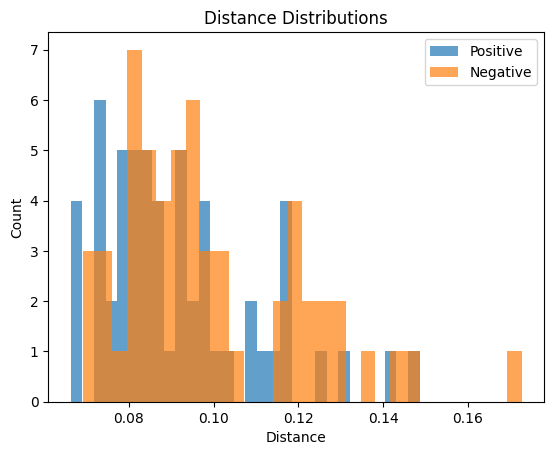

In [41]:
import matplotlib.pyplot as plt

plt.hist(pos_dist.numpy(), bins=30, alpha=0.7, label="Positive")
plt.hist(neg_dist.numpy(), bins=30, alpha=0.7, label="Negative")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.legend()
plt.title("Distance Distributions")
plt.show()


In [42]:
T = (pos_dist.mean() + neg_dist.mean()) / 2
print("Threshold:", T.item())


Threshold: 0.09530097991228104


In [43]:
import numpy as np

def find_eer_threshold(pos, neg):
    all_dists = torch.cat([pos, neg])
    thresholds = torch.linspace(
        all_dists.min(), all_dists.max(), steps=1000
    )

    best_t, best_diff = None, float("inf")

    for t in thresholds:
        far = (neg <= t).float().mean() 
        frr = (pos > t).float().mean()
        diff = abs(far - frr)

        if diff < best_diff:
            best_diff = diff
            best_t = t

    return best_t

T = find_eer_threshold(pos_dist, neg_dist)
print("EER Threshold:", T.item())


EER Threshold: 0.09099708497524261


In [44]:
def verify(sketch_embed, photo_embed, threshold):
    dist = F.pairwise_distance(
        sketch_embed.unsqueeze(0),
        photo_embed.unsqueeze(0)
    )
    return dist.item() <= threshold


In [45]:

print("True match:",
      verify(test_sketch_embeds[0],
             test_photo_embeds[0],
             T))


print("False match:",
      verify(test_sketch_embeds[0],
             test_photo_embeds[1],
             T))


True match: tensor(False)
False match: tensor(False)


In [46]:
import torch.nn.functional as F

d_true = F.pairwise_distance(
    test_sketch_embeds[0].unsqueeze(0),
    test_photo_embeds[0].unsqueeze(0)
)

d_false = F.pairwise_distance(
    test_sketch_embeds[0].unsqueeze(0),
    test_photo_embeds[1].unsqueeze(0)
)

print("True distance :", d_true.item())
print("False distance:", d_false.item())
print("Threshold     :", T.item())


True distance : 0.12427190691232681
False distance: 0.14085178077220917
Threshold     : 0.09099708497524261


In [47]:
print("Positive mean:", pos_dist.mean().item())
print("Negative mean:", neg_dist.mean().item())

print("Positive min/max:", pos_dist.min().item(), pos_dist.max().item())
print("Negative min/max:", neg_dist.min().item(), neg_dist.max().item())


Positive mean: 0.09159965813159943
Negative mean: 0.09900230169296265
Positive min/max: 0.06628000736236572 0.14867442846298218
Negative min/max: 0.06923563033342361 0.17271259427070618


In [48]:
T = pos_dist.mean() + pos_dist.std()
print("New threshold:", T.item())


New threshold: 0.11017470061779022


In [49]:
print("True match:",
      verify(test_sketch_embeds[0],
             test_photo_embeds[0],
             T))

print("False match:",
      verify(test_sketch_embeds[0],
             test_photo_embeds[1],
             T))


True match: tensor(False)
False match: tensor(False)


In [53]:
def verify(sketch_embed, photo_embed, threshold):
    dist = F.pairwise_distance(
        sketch_embed.unsqueeze(0),
        photo_embed.unsqueeze(0)
    ).item()
    return dist <= threshold


In [54]:
T = torch.quantile(pos_dist, 0.90).item()
print("Threshold:", T)


Threshold: 0.11696420609951019


In [55]:
print("True match:",
      verify(test_sketch_embeds[0],
             test_photo_embeds[0],
             T))

print("False match:",
      verify(test_sketch_embeds[0],
             test_photo_embeds[1],
             T))


True match: False
False match: False


In [56]:
def rank_k_accuracy(dist_matrix, k=1):
    correct = 0
    for i in range(dist_matrix.size(0)):
        topk = torch.topk(dist_matrix[i], k=k, largest=False).indices
        if i in topk:
            correct += 1
    return correct / dist_matrix.size(0)


In [57]:
rank1 = rank_k_accuracy(dist_matrix, k=1)
rank5 = rank_k_accuracy(dist_matrix, k=5)

print(f"Rank-1 Accuracy: {rank1:.3f}")
print(f"Rank-5 Accuracy: {rank5:.3f}")


Rank-1 Accuracy: 0.053
Rank-5 Accuracy: 0.105
